In [54]:
# import librairies
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from numpy import linalg as LA
import scipy.stats 
from scipy.stats import norm

In [55]:
n=2 # the dimension of data
N=1000 # the number of observations
kappa=10 # degree of concentration
true_mean = np.zeros([n,1]); true_mean[-1] = 1  # the true mean on the sphere

In [56]:
# Simulate spherical data from the von Mises-Fisher distribution
z=np.zeros([N,n])

for i in range(N):
    z[i,:]=np.random.vonmises(true_mean, kappa).T
    z[i,:]=z[i,:]/LA.norm(z[i,:]) # normalize data for consistency

In [57]:
# geometric tools on the sphere S^{n-1}
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.hypersphere import Hypersphere
sphere = Hypersphere(dim=n-1)

In [58]:
# find the Fréchet mean estimate
Fmean = FrechetMean(metric=sphere.metric)
Fmean.fit(z)
estimate_mean=Fmean.estimate_.reshape((n, 1))

In [59]:
# project data into the tangent space of the sphere at true_mean
x=np.zeros([N,n])
for i in range(N):
    x[i,:]=z[i,:]/np.inner(np.array(z[i,:]),true_mean.T)

In [60]:
# evaluate the resultant
SN=np.sum([x],1).T

In [61]:
# estimate the mean and std of concentrations: E(c) and \sqrt{Var(c)}
inner_product=np.zeros([N,1])
for i in range(N):
    inner_product[i]=np.inner(np.array(z[i,:]),estimate_mean.T)
    
mean_c=LA.norm(SN)/(N*LA.norm(np.mean([z],1)));    
    
std_c=np.sqrt(np.mean(1./inner_product**2) - mean_c**2)    

In [62]:
# all possible p-values with a precision of 0.01 for this example
p=np.linspace(0,1,101)

In [63]:
# find the quantile of standard normal distribution
q = scipy.stats.norm.ppf(1-p/2)
# estimate sigma^2
mat=np.zeros([n,n])
for i in range(N):
    mat+=np.dot(z[i,:].reshape((n, 1)), z[i,:].reshape((1, n)))
    
sigma2=(std_c**2)*np.dot(np.dot(np.mean([z],1).reshape((1,n)),mat),np.mean([z],1).reshape((n,1)))/N
# find the thresholds
threshold1=(mean_c*LA.norm(np.mean([z],1))**2+(q*np.sqrt(sigma2))/np.sqrt(N)).reshape((np.shape(p)[0],1))
threshold2=(mean_c*LA.norm(np.mean([z],1))**2-(q*np.sqrt(sigma2))/np.sqrt(N)).reshape((np.shape(p)[0],1))

In [64]:
# the statistic value
T = LA.norm(np.mean([z], 1)) * LA.norm(SN) / N 

M = np.zeros([threshold1.shape[0], 1]) 

for i in range(threshold1.shape[0]):
    if np.any(T >= threshold1[i]) or np.any(T <= threshold2[i]):
        M[i] = 1
    else:
        M[i] = 0

# find the p-value        
p_value=p[list(np.array(M) == 1).index(True)]
print(p_value)

1.0


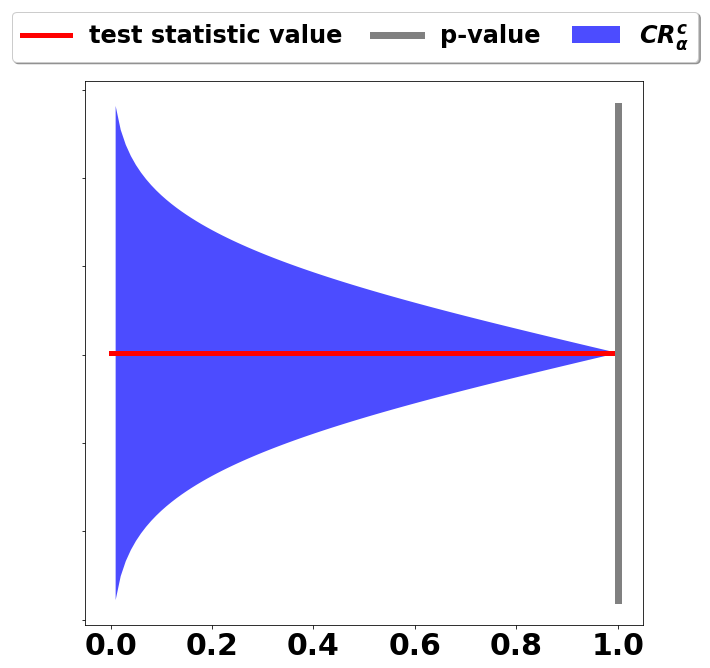

In [65]:
# illustration of the p-value, the statistic value and the critical region
plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'legend.fontsize': 24})
plt.rcParams['font.weight'] = 'bold'

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.fill(np.concatenate([p, p[::-1]]),np.concatenate([threshold1,(threshold2)[::-1]]),alpha=.7, fc='b', ec='None', label='$CR_{\\alpha}^{c}$')    
  
ax.set_yticklabels([])

plt.plot([0,1], [T,T], linewidth=5,color='r', label='test statistic value')
plt.plot([p_value, p_value], [threshold1[1], threshold2[1]], linewidth=7, color='gray', label='p-value')

fig.legend(loc='upper left',ncol=5,mode="expand",shadow=True,fancybox=True)

(-1.2, 1.2, -1.2, 1.2)

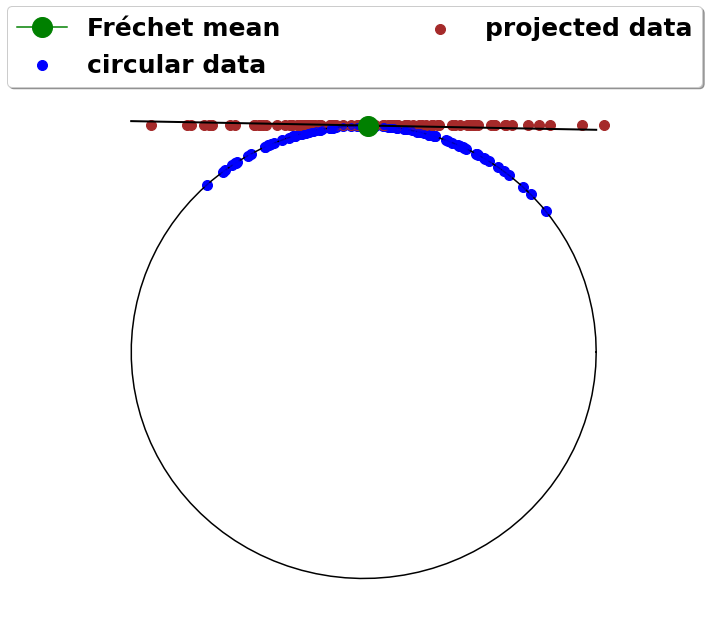

In [66]:
# illustration of some (here 100) circular data, their Fréchet mean and their projections
import geomstats.visualization as visualization
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

sphere = Hypersphere(dim=1)

plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'legend.fontsize': 22})
plt.rcParams['font.weight'] = 'bold'

fig = plt.figure(figsize=(10, 10))

ax = visualization.plot(z[0:99,:], space='S1', color='blue', alpha=0.7)

ax.scatter(z[0:99,0], z[0:99,1], color='blue', marker='o', s=100, label='circular data')

t1=np.linspace(-1,1,20)

s1=(1-estimate_mean[0]*t1)/estimate_mean[1]

ax.plot(t1,s1,linewidth=2,color='black')

ax.scatter(x[0:99,0], x[0:99,1], color='brown', marker='o', s=100, label='projected data')

plt.plot(estimate_mean[0,],estimate_mean[1,], color='green', marker='o', markersize=20, label='Fréchet mean')

fig.legend(loc='upper left', bbox_to_anchor=(0, 0.5, 1, 0.5), ncol=2,mode="expand",shadow=True,fancybox=True,fontsize="small")

plt.axis('off')

In [67]:
# density of ||S_N||*||\bar{z}||/N
t=np.linspace(mean_c*(LA.norm(np.mean([z],1))**2)-0.5,mean_c*(LA.norm(np.mean([z],1))**2)+0.5,100)
    
density=norm.pdf(t, mean_c*(LA.norm(np.mean([z],1))**2), sigma2)    

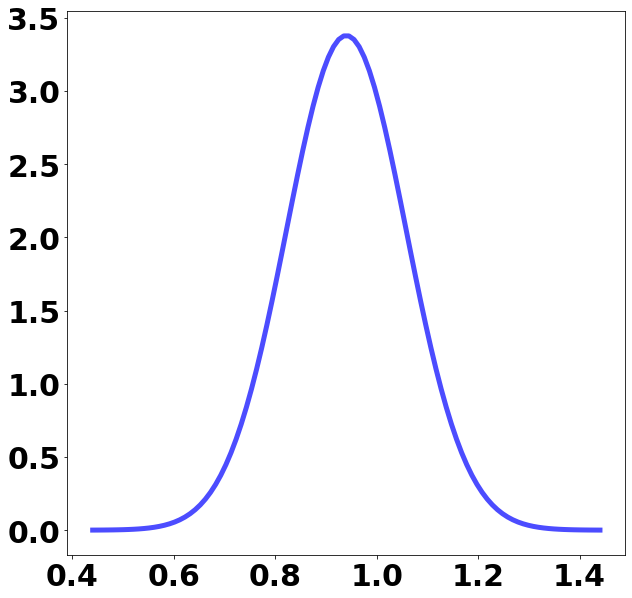

In [68]:
plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'legend.fontsize': 24})
plt.rcParams['font.weight'] = 'bold'

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.plot(t,density.T,color='b', lw=5, alpha=0.7)